In [1]:
!pip install fairlearn shap


### Imports

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from fairlearn.metrics import MetricFrame, selection_rate
import shap


### Loading dataset

In [3]:
df = pd.read_csv("data.csv")
df.head()


,sno,age,gender,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,male,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,yes
1,1,37,male,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,yes
2,2,41,female,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,yes
3,3,56,male,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,yes
4,4,57,female,0,NaN,354.0,0,1,163.0,1,0.6,2,0,2,yes


### Preparing x and Y of data set 
## by dropping the target column

In [4]:
X = df.drop(columns=["target"])
y = df["target"].replace({"yes": 1, "no": 0})


/var/tmp/ipykernel_15897/2863932283.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df["target"].replace({"yes": 1, "no": 0})


### Age Bining


In [5]:
age_bins = [0, 20, 40, 60, 80, 120]
age_labels = ["0-20", "21-40", "41-60", "61-80", "80+"]

X["age_group"] = pd.cut(
    X["age"],
    bins=age_bins,
    labels=age_labels
)


In [8]:
# Identify categorical columns (object type)
cat_cols = X.select_dtypes(include="object").columns
print("Categorical columns:", cat_cols)

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


Categorical columns: Index(['gender'], dtype='object')


### Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=["age_group"]),
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


## Training Basic model

In [11]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=["age_group"]),
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 1.0


In [20]:
# ============================
# FAIRNESS ANALYSIS CELL
# ============================

from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# Create age buckets of 20 years as required
# This groups patients into comparable age categories
age_bins = [0, 20, 40, 60, 80, 120]
age_labels = ["0-20", "21-40", "41-60", "61-80", "80+"]

age_group = pd.cut(
    df.loc[y_test.index, "age"],
    bins=age_bins,
    labels=age_labels
)

# Use Fairlearn MetricFrame to compute metrics per age group
# - accuracy: how well the model performs
# - selection_rate: how often heart disease is predicted
mf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=age_group
)

# Display metrics for each age group
mf.by_group


,accuracy,selection_rate
age,,
21-40,1.0,0.714286
41-60,1.0,0.590164
61-80,1.0,0.391304


Heart disease samples used for SHAP: 50


  0%|          | 0/50 [00:00<?, ?it/s]

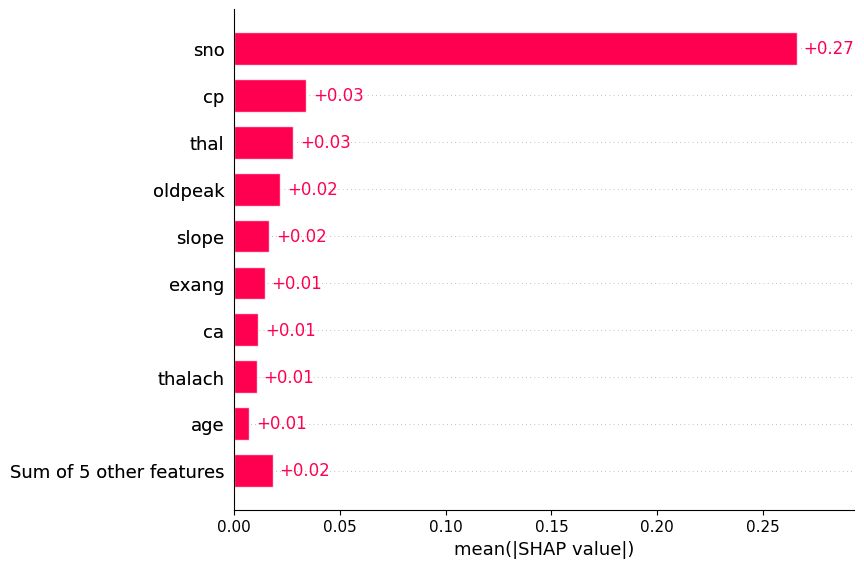

In [25]:
# ============================
# SHAP EXPLAINABILITY (FINAL, STABLE, NO SHAPE ISSUES)
# ============================

import shap
import pandas as pd

# Recreate encoded features exactly as training
X_encoded = pd.get_dummies(
    df.drop(columns=["target"]),
    drop_first=True
)

# Align with test set
X_test_encoded = X_encoded.loc[X_test.index]

# Select heart disease samples
X_hd_encoded = X_test_encoded[y_test == 1]

print("Heart disease samples used for SHAP:", X_hd_encoded.shape[0])

# KernelExplainer (model-agnostic, stable)
explainer = shap.KernelExplainer(
    clf.predict_proba,
    X_test_encoded.sample(50, random_state=42)
)

# Compute SHAP values
shap_values = explainer(X_hd_encoded)

# FINAL SHAP PLOT (bar plot handled by SHAP)
shap.plots.bar(shap_values[:, :, 1])
